In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Importing data

In [3]:
data = pd.read_csv(r'/content/drive/MyDrive/classification_train.csv')

In [4]:
#importing dataset
x = data.iloc[:20000,2:786].values

y = data.iloc[:20000,1].values
y = y.reshape(y.shape[0],1)
x

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [5]:
m, n = x.shape
x.shape,y.shape 

((20000, 784), (20000, 1))

In [6]:
mu     = np.mean(x,axis=0)   
sigma  = np.std(x,axis=0) 
x_mean = (x - mu)
x_norm = (x - mu)/sigma
X=x_norm.T
X.shape

(784, 20000)

In [7]:
""" Y: onehot encoded """
unique_values=(np.unique(y))
Y=np.zeros((m,len(unique_values)))
for i in range(m):
    for j in range(len(unique_values)):
        if y[i][0]==unique_values[j]: Y[i][unique_values[j]]=1 

y=Y.T
y.shape

(10, 20000)

# Activation functions¶

In [8]:
def relu(x):
    return np.maximum(x, 0)

def softmax(x):
    expX = np.exp(x)
    return expX/np.sum(expX, axis = 0)
def tanh(x):
    return np.tanh(x)

In [9]:
def derivative_relu(x):
    return np.array(x > 0, dtype = np.float32)
def derivative_tanh(x):
    return (1 - np.power(np.tanh(x), 2))

# Initialize Parameters

In [10]:
def initialize_parameters(layer_dims):
    
    parameters = {}
    L = len(layer_dims)            

    for l in range(1, L):
        # parameters['W' + str(l)] = (np.random.randn(layer_dims[l], layer_dims[l-1]))*0.001
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01

        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
    return parameters

In [11]:
a=[]
print("no. of hidden layers:")
b=int(input())
print("number of neurons in each layer")
for i in range(b):
#     print('number of neurons in layer ' + str{l})
    l=int(input())
    a.append(l)
a

no. of hidden layers:
3
number of neurons in each layer
50
25
15


[50, 25, 15]

In [12]:
c = X.shape[0]
a.insert(0,c)
# c.append(a)
d = int(y.shape[0])
a.append(d)
a
layer_dims = a
print(layer_dims)
params = initialize_parameters(layer_dims)

for l in range(1, len(layer_dims)):
    print("Shape of W" + str(l) + ":", params['W' + str(l)].shape)
    print("Shape of B" + str(l) + ":", params['b' + str(l)].shape, "\n")

[784, 50, 25, 15, 10]
Shape of W1: (50, 784)
Shape of B1: (50, 1) 

Shape of W2: (25, 50)
Shape of B2: (25, 1) 

Shape of W3: (15, 25)
Shape of B3: (15, 1) 

Shape of W4: (10, 15)
Shape of B4: (10, 1) 



# Forward Propagation

In [13]:
def forward_propagation(X, parameters):
   
    forward_cache = {}
    L = len(parameters) // 2    
    
    forward_cache['A0'] = X

    for l in range(1, L):
        forward_cache['Z' + str(l)] = parameters['W' + str(l)].dot(forward_cache['A' + str(l-1)]) + parameters['b' + str(l)]
        

        forward_cache['A' + str(l)] = relu(forward_cache['Z' + str(l)])
            

    forward_cache['Z' + str(L)] = parameters['W' + str(L)].dot(forward_cache['A' + str(L-1)]) + parameters['b' + str(L)]
    
    
    
    forward_cache['A' + str(L)] = softmax(forward_cache['Z' + str(L)])
    
    return forward_cache['A' + str(L)], forward_cache

In [14]:
AL, forw_cache = forward_propagation(X, params)
for l in range(len(params)//2 + 1):
    print("Shape of A" + str(l) + " :", forw_cache['A' + str(l)].shape)

Shape of A0 : (784, 20000)
Shape of A1 : (50, 20000)
Shape of A2 : (25, 20000)
Shape of A3 : (15, 20000)
Shape of A4 : (10, 20000)


# Cost function

In [15]:
def compute_cost(AL, Y):
    cost = -(1./m) * np.sum(y * np.log(AL))
    cost = np.squeeze(cost)
    return cost

# Backpropagation

In [16]:
def backward_propagation(AL, y, parameters, forward_cache):
    
    grads = {}
    L = len(parameters)//2
    
    grads["dZ" + str(L)] = AL - y
    grads["dW" + str(L)] = 1./m * np.dot(grads["dZ" + str(L)],forward_cache['A' + str(L-1)].T)
    grads["db" + str(L)] = 1./m * np.sum(grads["dZ" + str(L)], axis = 1, keepdims = True)
    
    for l in reversed(range(1, L)):
        
        
        grads["dZ" + str(l)] = np.dot(parameters['W' + str(l+1)].T,grads["dZ" + str(l+1)])*derivative_relu(forward_cache['A' + str(l)])
            
        grads["dW" + str(l)] = 1./m * np.dot(grads["dZ" + str(l)],forward_cache['A' + str(l-1)].T)
        grads["db" + str(l)] = 1./m * np.sum(grads["dZ" + str(l)], axis = 1, keepdims = True)

    return grads

In [17]:
grads = backward_propagation(forw_cache["A" + str(b+1)], y, params, forw_cache)

# Gradient descent

In [18]:
def update_parameters(parameters, grads, learning_rate):

    L = len(parameters) // 2 
    
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

In [19]:
def model(X, y, layers_dims, learning_rate = 0.03, activation = 'relu', num_iterations = 3000):

    costs = []              
    
    parameters = initialize_parameters(layer_dims)

    for i in range(0, num_iterations):

        AL, forward_cache = forward_propagation(X, parameters)

        cost = compute_cost(AL, Y)

        grads = backward_propagation(AL, y, parameters, forward_cache)

        parameters = update_parameters(parameters, grads, learning_rate)
        
        costs.append(cost)

        if i % (num_iterations/10) == 0:
            print('iterations = '+ str(i) + ' cost = ' + str(cost))
        
        
       
    return parameters,costs

In [20]:
lr = 0.009
iters = 2500

parameters,costs = model(X, y, layer_dims, learning_rate = lr, activation = 'relu', num_iterations = iters)

iterations = 0 cost = 2.339407978602308
iterations = 250 cost = 1.1609545384954905
iterations = 500 cost = 0.7206475402349102
iterations = 750 cost = 0.6001089944580688
iterations = 1000 cost = 0.5437828630472133
iterations = 1250 cost = 0.5077766559458278
iterations = 1500 cost = 0.4811315284008757
iterations = 1750 cost = 0.45930910301857814
iterations = 2000 cost = 0.44011023563936946
iterations = 2250 cost = 0.42259213673579615


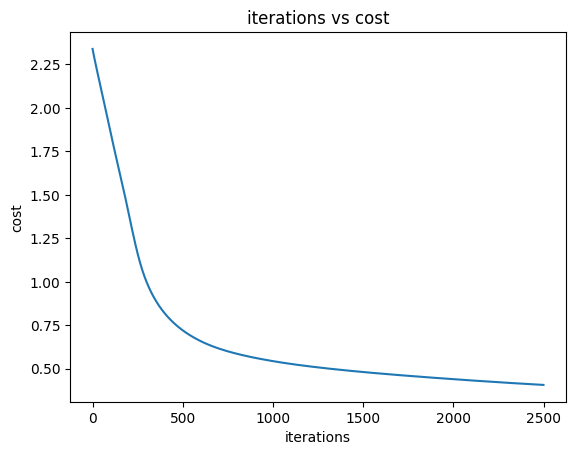

In [21]:
t = np.arange(0, iters)
plt.plot(t,costs)
plt.xlabel("iterations")
plt.ylabel("cost")
plt.title("iterations vs cost")

plt.show()

# Accuracy on train data

In [22]:
y_pred,_ = forward_propagation(X, parameters)
    
    
    
y = np.argmax(y, axis =0)
y_pred = np.argmax(y_pred, axis = 0)

In [23]:
count=0
for i in range(m):
    
    if y[i] ==y_pred[i]:
        count+=1 
print(count)

17135


In [24]:
accuracy=(count/m)*100
print('Accuracy on train data = '+str(accuracy)+'%')

Accuracy on train data = 85.675%


# Accuracy on test data 

In [25]:
x_test = data.iloc[20000:,2:786].values
m_test,n_test=x_test.shape
y_test=data.iloc[20000:,1].values
y_test = y_test.reshape(y_test.shape[0],1)
y_test.shape

(10000, 1)

In [26]:
mu     = np.mean(x_test,axis=0)   
sigma  = np.std(x,axis=0) 
x_mean = (x_test - mu)
x_norm_test = (x_test - mu)/sigma
x_test=x_norm_test.T

In [27]:
y_pred_test,_ = forward_propagation(x_test, parameters)
    
    
    
# y = np.argmax(y, axis =0)
y_pred_test = np.argmax(y_pred_test, axis = 0)

In [28]:
count=0
for i in range(m_test):
    
    if y_pred_test[i] ==y_test[i]:
        count+=1 
print(count)

8454


In [29]:
accuracy=(count/m_test)*100
print('Accuracy on test data = '+str(accuracy)+'%')

Accuracy on test data = 84.54%
